# Стратегия взаимодействия с клиентами фитнес-центров 
# "Культурист - датасаентист"

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. **Наша задача — провести анализ и подготовить план действий по удержанию клиентов.**

## Импортируем необходимые библиотеки для работы

In [14]:
import pandas as pd
import math as mth
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage


import warnings
warnings.filterwarnings('ignore')  

## Загружаем данные

In [15]:
fitnes = pd.read_csv('/datasets/gym_churn.csv')
fitnes.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


### Поля

Данные клиента за предыдущий до проверки факта оттока месяц:
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).
Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `Churn` — факт оттока в текущем месяце.

In [16]:
# приведем названия столбцов к нижнему регистру
fitnes.columns = fitnes.columns.str.lower()

## Исследовательский анализ данных (EDA)

### Рассмотрим отсутствующие признаки, средние значения и стандартные отклонения

In [17]:
#изучим общую информацию о датасете
fitnes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

* Пропущенных значений признаков нет, все признаки имеют количественный тип данных

In [18]:
fitnes.duplicated().sum()

0

In [19]:
fitnes.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
3995    False
3996    False
3997    False
3998    False
3999    False
Length: 4000, dtype: bool

**Дубликатов не обнаружено**

**Рассмотрим средние значения и стандартные отклонения**

In [20]:
fitnes.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


**О чем они нам говорят:**
- почти равное соотношение по половому признаку
- около 85% посетителей проживают или работают около фитнес-центра
- почти половина клиентов являются сотрудником компании-партнера
- 30% посетителей пришли в рамках акции "приведи друга"
- 90% посетителей указали свой номер телефона
- среднее время абонемента - 4.7 месяцев, но так как всего 3: 1,6 и 12 мес., то скорее всего абонемент на полгода
- 41% посещает групповые занятия
- средний возраст - 29 лет
- каждый клиент в среднем тратит около 150 руб. на доп.услуги в зале
- до окончания абонемента у клиентов в среднем 4.3 месяца
- время с момента первого посещения в среднем 3.7 месяцев (почти 4)
- в среднем за неделю клиенты посещают зал 1.8 раз
- в среднем за неделю предыдущего месяца клиенты посещали фитнес клуб чуть меньше 1.7 против 1.8 раз
- факт оттока - 26,5 % клиентов

### Рассмотрим средние значения признаков в двух группах - тех, кто остался и тех, кто ушел

In [21]:
fitnes.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


**Что видим для тех, кто остался:**
- также почти равное соотношение по половому признаку
- уже 87% посетителей проживают или работают около фитнес-центра
- 53% клиентов являются сотрудником компании-партнера
- 35% посетителей пришли в рамках акции "приведи друга"
- 90% посетителей указали свой номер телефона
- среднее время абонемента - 5.7 месяцев, но так как всего 3: 1,6 и 12 мес., то скорее всего абонемент на полгода
- 46% посещает групповые занятия
- средний возраст - 30 лет
- каждый клиент в среднем тратит около 158 руб. на доп.услуги в зале
- до окончания абонемента у клиентов в среднем 5.2 месяца
- время с момента первого посещения в среднем 4.7 месяцев (почти 4)
- в среднем за неделю клиенты посещают зал 2 раза
- в среднем за неделю предыдущего месяца клиенты посещали фитнес клуб также 2 раза



**Что видим для тех, кто ушел:**
- также почти равное соотношение по половому признаку
- меньше посетителей проживают или работают около фитнес-центра - 77%
- 18.3% клиентов являются сотрудником компании-партнера
- 35% посетителей пришли в рамках акции "приведи друга"
- 90% посетителей указали свой номер телефона
- среднее время абонемента - всего 1.7 месяцев
- 27% посещает групповые занятия
- средний возраст - 27 лет
- каждый клиент в среднем тратит около 115 руб. на доп.услуги в зале
- до окончания абонемента у клиентов в среднем 1.6 месяца
- время с момента первого посещения в среднем 1 месяц
- в среднем за неделю клиенты посещают зал 1.47 раза
- в среднем за неделю предыдущего месяца клиенты посещали фитнес клуб 1 раз



### Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл и тех, кто остался

In [22]:
fitnes.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [23]:
fitnes_columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']

**Построим столбчатые гистограммы**

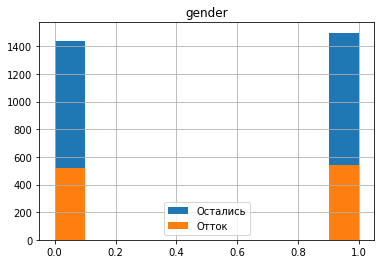

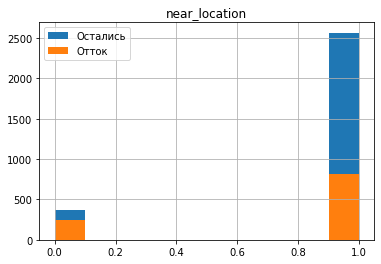

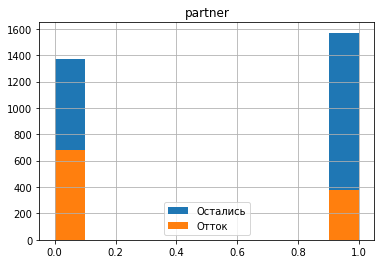

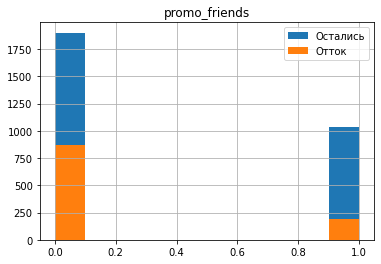

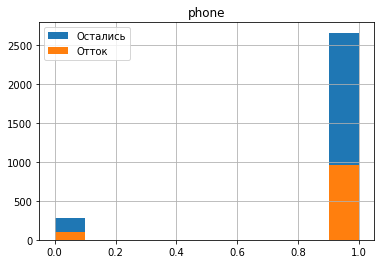

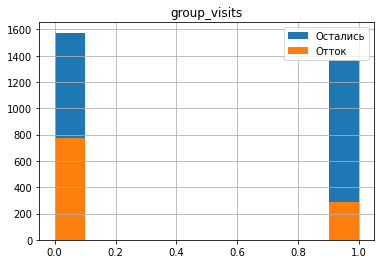

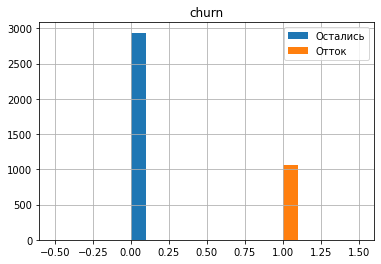

In [24]:
for column in fitnes_columns:
    fitnes.groupby('churn')[column].hist()
    plt.title(column)
    plt.legend(['Остались', 'Отток'])
    plt.show()

**Распределение признаков**

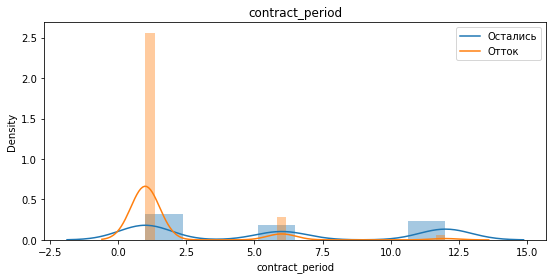

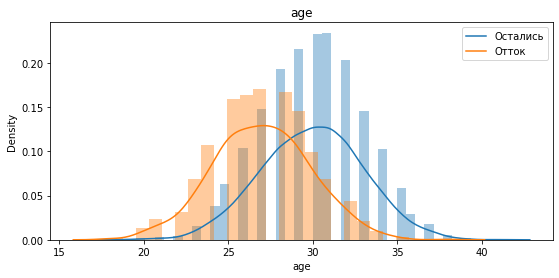

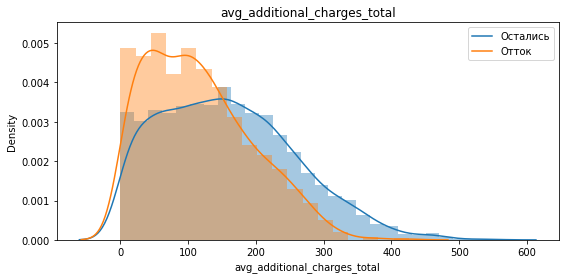

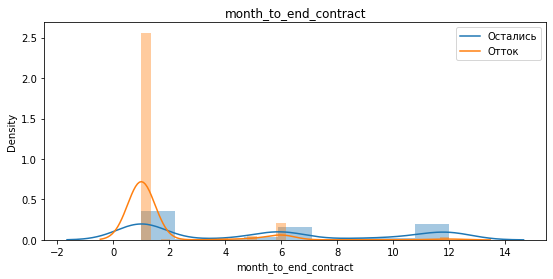

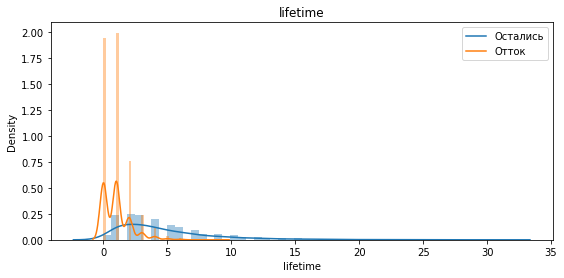

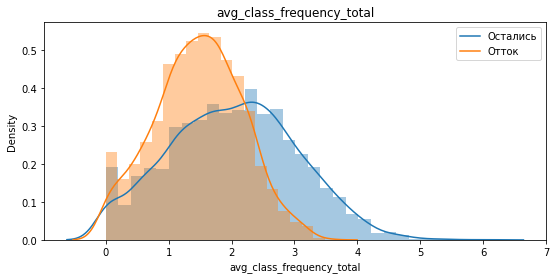

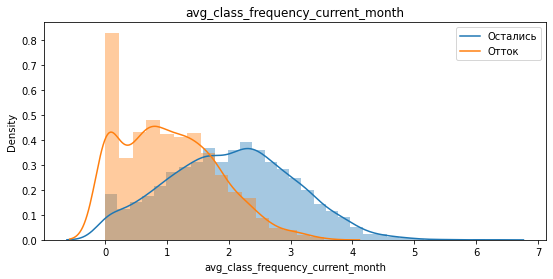

In [25]:
for column in fitnes.columns:
    if column not in fitnes_columns:
        plt.figure(figsize=(9,4))
        plt.title(column)
        sns.distplot(fitnes[fitnes['churn']==0][column])
        sns.distplot(fitnes[fitnes['churn']==1][column])
        plt.legend([ 'Остались', 'Отток'])
        plt.show()

**Заметно, что клиенты, которые остались более активны**

*Больше людей пришло в рамках акции приведи друга, у них абонементы на более долгий период, чаще посещают фитнес клуб и групповые занятия, тратят больше денег на доп.услуги*

**Клиенты, попавшие в отток, заметно отличаются**

*Меньше людей проживают или работаю вблизи фитнес-центра, лишь 18.3% являются сотрудниками партнеров, намного меньше людей пришло в рамках акции приведи друга, абонементы на срок не более 2х месяцев, только 27% посещают групповые занятия. Такие клиенты моложе на 3 года, меньше денег тратят на доп.услуги и ощутимо реже посещают занятия*

### Построим матрицу корреляций

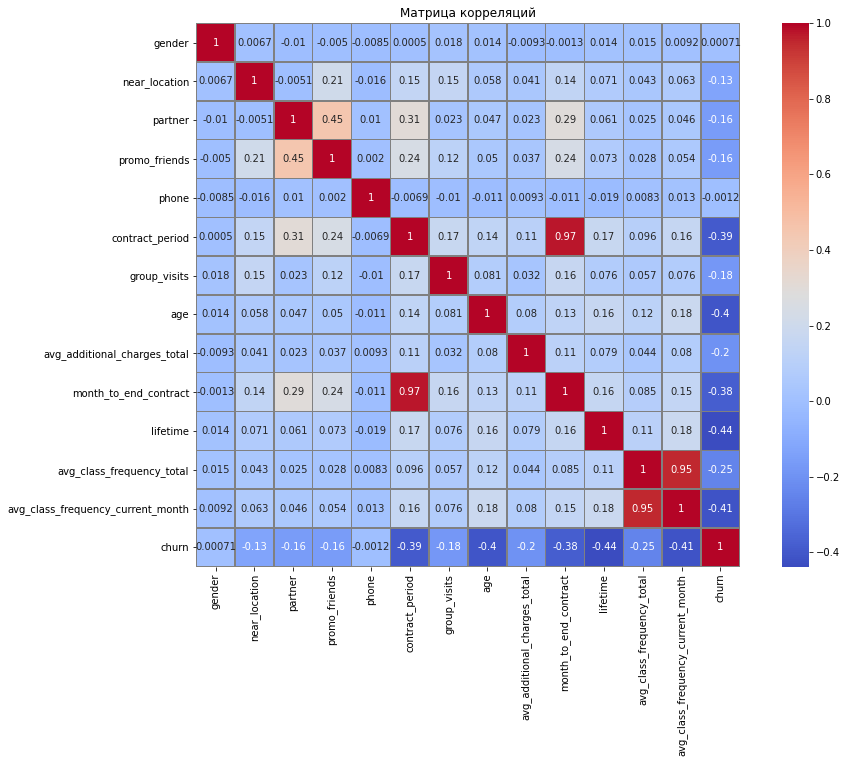

In [26]:
plt.figure(figsize=(15,10))
plt.title('Матрица корреляций')
sns.heatmap(fitnes.corr(), annot = True, square=True, cmap= 'coolwarm', linewidths=0.5, linecolor='grey');

* Присутствуют два мультиколлинеарных признака - `contract_period` и `month_to_end_contract'`, но сильной корреляции оттока от других признаков не наблюдается.

In [27]:
fitnes = fitnes.drop('month_to_end_contract', axis = 1)

## Построим модель прогнозирования оттока клиентов

**Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце**

* Разобьем данные на обучающую и валидационную выборку функцией train_test_split()
* Обучим модель на train-выборке двумя способами:
    - логистической регрессией,
    - случайным лесом.
* Оценим метрики `accuracy`, `precision` и `recall` для обеих моделей на валидационной выборке.

In [28]:
# разделите наши данные на признаки (X) и целевую переменную (y)
X = fitnes.drop('churn', axis = 1)
y = fitnes['churn']

# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [29]:
# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
# обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_train_st = scaler.fit_transform(X_train)  
# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

**Логистическая регрессия**

* Обучая логистическую регрессию, можно столкнуться с предупреждением библиотеки sklearn о том, что в будущем алгоритм решения по умолчанию, так называемый солвер, будет изменён. Чтобы его отключить, укажем аргумент solver=`liblinear`

In [30]:
# задаём алгоритм для нашей модели
model_l = LogisticRegression(solver='liblinear', random_state=0) 

# обучаем модель
model_l.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [31]:
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions_l = model_l.predict(X_test) 
# оценка вероятности принадлежности ко второму классу (среди классов "0" и "1", имеем в виду класс "1")
probabilities_l = model_l.predict_proba(X_test)[:,1]

In [32]:
print('Метрики модели логистической регрессии:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions_l)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions_l)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions_l)))

Метрики модели логистической регрессии:
Accuracy: 0.93
Precision: 0.86
Recall: 0.83


**Случайный лес**

In [33]:
# алгоритм для этой модели на основе алгоритма случайного леса
model_ranf = RandomForestClassifier(n_estimators = 100, random_state = 0)

#мы задали "n_estimators" = 100 — число деревьев, на основании которых будем строить лес. 

In [34]:
# обучим модель случайного леса
model_ranf.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions_ranf = model_ranf.predict(X_test_st)
probabilities_ranf = model_ranf.predict_proba(X_test_st)[:, 1]

In [35]:
print('Метрики модели логистической регрессии:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions_ranf)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions_ranf)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions_ranf)))

Метрики модели логистической регрессии:
Accuracy: 0.91
Precision: 0.83
Recall: 0.81


**Вывод**
* Доля правильных прогнозов `accuracy` лучше у модели логистической регрессии (93%)
* Доля правильных ответов только среди целевого класса `precision` также лучше у модели логистической регрессии
* `recall` показывает, сколько реальных объектов "1" класса у нас получилось обнаружить. Данная метрика также лучше показала себя в модели логистической регрессии (83%)

## Кластеризация клиентов

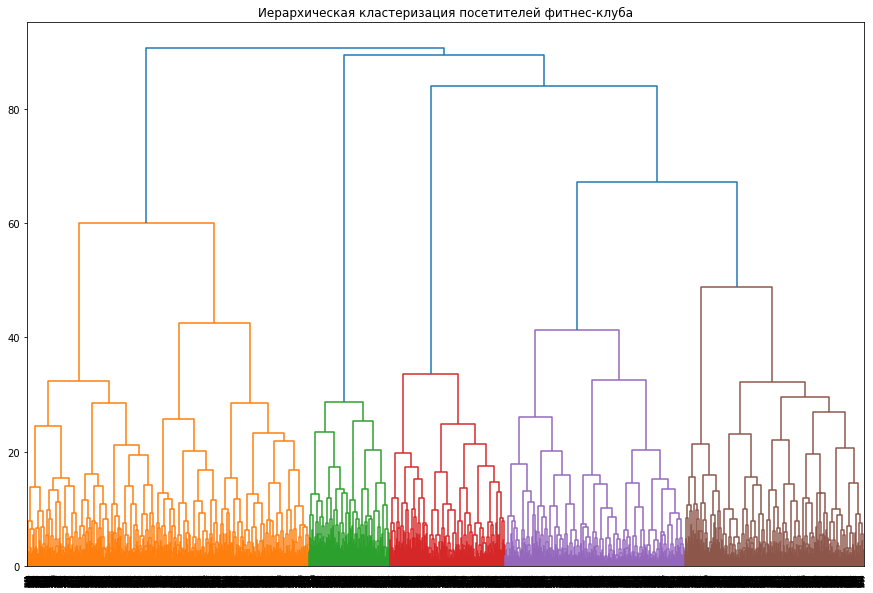

In [36]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward') 

#В переменной linked сохранена таблица «связок» между объектами. Её можно визуализировать как дендрограмму:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация посетителей фитнес-клуба')
plt.show() 

- На основании графика можно предположить о том, что можно выделить ***5 кластеров***

* Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Договоримся за число кластеров принять **n=5**

**Важное примечание**
В задании было обозначено провести кластеризацию без учета столбца с оттоком

**Статистика приведена сначала для данных без этого параметра, а потом с учетом оттока**

In [37]:
# задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
km = KMeans(n_clusters=5, random_state=0) 

# применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(X_sc)

In [38]:
X['cluster'] = labels

In [39]:
# выводим статистику по средним значениям наших признаков по кластеру
display(X.groupby('cluster').mean())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
cluster,,,,,,,,,,,,
0,0.478392,0.993970,0.947739,0.879397,1.000000,7.831156,0.536683,29.629146,154.788356,4.447236,1.836547,1.795608
1,0.524675,0.862338,0.472727,0.306494,0.000000,4.758442,0.425974,29.283117,144.240418,3.922078,1.846575,1.716160
2,0.494515,1.000000,0.240506,0.095359,1.000000,2.483544,0.331646,28.216034,131.341969,2.440506,1.255953,1.030234
3,0.568736,0.970067,0.307095,0.097561,0.998891,5.137472,0.483370,30.288248,166.180576,5.011086,2.879208,2.882946
4,0.495310,0.000000,0.487805,0.075047,1.000000,2.859287,0.228893,28.566604,136.384285,2.911820,1.674358,1.500208


**Кластер 0** :
   - 99% живут или работают возле фитнес-клуба
   - 94% сотрудников компаний-партнеров
   - 87% пришли в рамках акции "приведи друга"
   - длительность текущего абонемента более полугода
   - 54% посещают групповые занятия
   - траты на доп.услуги - 155 руб.
   - времени с момента первого посещения - около 5 месяцев
   - около 1.8 посещений в месяц
   
**Кластер 1** :
   - 86% живут или работают возле фитнес-клуба
   - 47% сотрудников компаний-партнеров
   - 30% пришли в рамках акции "приведи друга"
   - приблизительно полугодовой абонемент
   - 42% посещают групповые занятия
   - траты на доп.услуги - 144 руб.
   - времени с момента первого посещения - около 4 месяцев
   - около 1.8 посещений в месяц

**Кластер 2** :
   - каждый проживает или работает около фитнес-клуба
   - 24% сотрудников компаний-партнеров
   - лишь 9% пришли в рамках акции "приведи друга"
   - абонемент в среднем на 2 месяца
   - 33% посещают групповые занятия
   - траты на доп.услуги - 131 руб.
   - времени с момента первого посещения - не больше 3 месяцев
   - в среднем одно посещение клуба в неделю

**Кластер 3** :
   - 97% живут или работают возле фитнес-клуба
   - 30% сотрудников компаний-партнеров
   - лишь 9% пришли в рамках акции "приведи друга"
   - абонемент около 5 месяцев
   - 48% посещают групповые занятия 
   - траты на доп.услуги - 166 руб.
   - времени с момента первого посещения - более 5 месяцев
   - в среднем почти 3 посещения клуба в неделю

**Кластер 4** :
   - ни один посетитель не живет и не работает около фитнес-клуба
   - 48% сотрудников компаний-партнеров
   - лишь 7% пришли в рамках акции "приведи друга"
   - абонемент в среднем на 3 месяца
   - 22% посещают групповые занятия 
   - траты на доп.услуги - 136 руб - максимальные
   - срок до окончания абонемента - около 3 месяцев
   - чуть больше 1 посещения в неделю

**Построим распределение признаком для кластеров с учетом *оттока***

In [40]:
fitnes['cluster'] = labels

In [41]:
# выводим статистику по средним значениям наших признаков по кластеру
display(fitnes.groupby('cluster').mean())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,
0,0.478392,0.993970,0.947739,0.879397,1.000000,7.831156,0.536683,29.629146,154.788356,4.447236,1.836547,1.795608,0.102513
1,0.524675,0.862338,0.472727,0.306494,0.000000,4.758442,0.425974,29.283117,144.240418,3.922078,1.846575,1.716160,0.267532
2,0.494515,1.000000,0.240506,0.095359,1.000000,2.483544,0.331646,28.216034,131.341969,2.440506,1.255953,1.030234,0.502110
3,0.568736,0.970067,0.307095,0.097561,0.998891,5.137472,0.483370,30.288248,166.180576,5.011086,2.879208,2.882946,0.041020
4,0.495310,0.000000,0.487805,0.075047,1.000000,2.859287,0.228893,28.566604,136.384285,2.911820,1.674358,1.500208,0.420263


**Кластер 0** (отток - **10%**):
   - живут или работают близко к фитнес клубу
   - абонемент на срок более полугода
   - 88% работают в компании-партнере
   - хорошо посещают груповые занятия и тратят деньги на доп.услуги
   - почти 2 посещения в неделю за прошлый и текущий месяц
   
**Кластер 1** (отток - **26%**):
   - большинство живут или работают близко к фитнес клубу
   - половина клиентов из компаний-партнеров
   - абонемент в среднем до 5 месяцев
   - почти 2 посещения в неделю за прошлый и текущий месяц

**Кластер 2** (отток - **50%**):
   - каждый посетитель работает или живет рядом с клубом
   - 24% из компаний-партнеров
   - малое количество пришло по акции "Приведи друга"
   - абонемент меньше на период около 2 месяцев
   - одно посещение (около 1.5) в неделю за прошлый и текущий месяц

**Кластер 3** (отток - **4%**):
   - большинство живут или работают близко к фитнес клубу
   - 30% сотрудников компаний-партнеров
   - 9% пришли в рамках акции "приведи друга"
   - абонемент около полугода
   - почти 3 посещения клуба в неделю

**Кластер 4** (отток - **42%**):
   - не живут и не работают возле клуба
   - 48% сотрудников компаний-партнеров
   - 7% пришли в рамках акции "приведи друга"
   - абонемент в среднем на 3 месяца
   - менее двух посещений в неделю

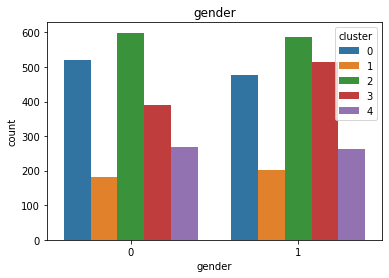

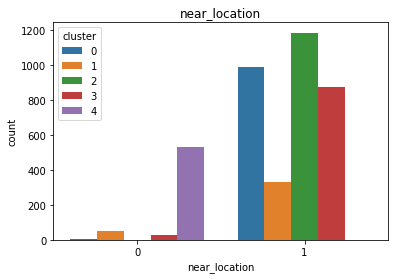

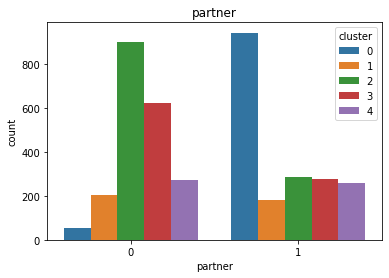

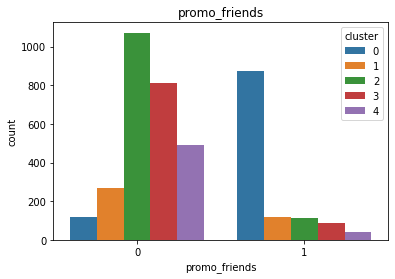

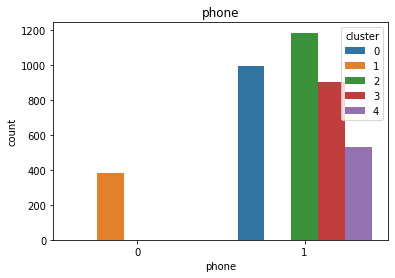

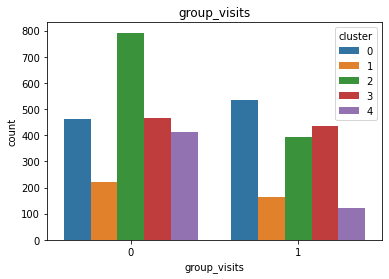

In [42]:
binar_columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']
for column in binar_columns:
    plt.figure(figsize=(6, 4))
    #посмотрим на распределение в каждом столбце с помощью столбчатой диаграммы
    sns.countplot(x = fitnes[column], hue='cluster', data=fitnes)
    plt.title(column)
    plt.show()

In [45]:
nebinar_columns = ['contract_period', 'age', 'avg_additional_charges_total', 'lifetime',
                   'avg_class_frequency_total', 'avg_class_frequency_current_month']

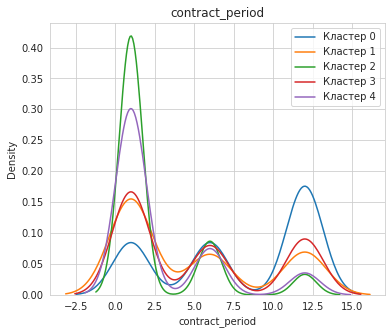

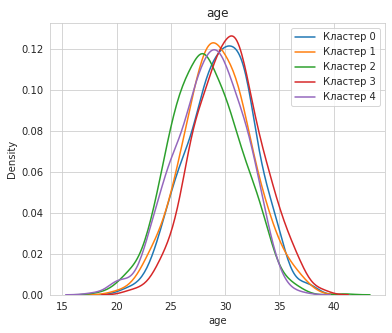

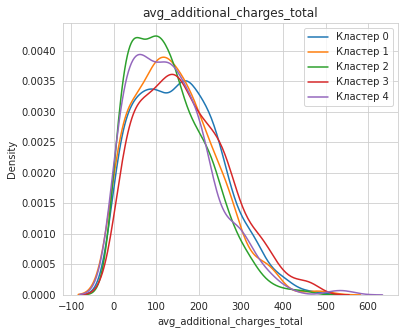

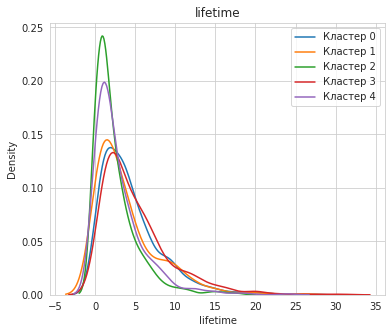

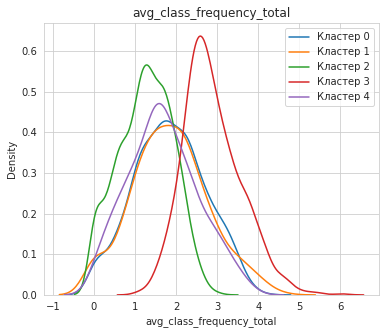

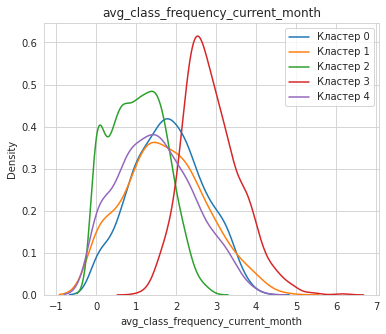

In [46]:
for column in nebinar_columns:
    plt.figure(figsize=(6, 5))
    plt.title(column)
    for i in range (0, 5):
        sns.kdeplot(fitnes.query('cluster==@i')[column], label = 'Кластер {}'.format(i))
    sns.set_style('whitegrid')
    plt.legend()
    plt.show()

**Выводы**
- Заметно, что кластеры отличаются по доле оттока. Клиенты, попавшие в кластеры 2 и 4 показали максимальный отток, несмотря на то, что среди них те, кто живет или работает рядом. У них самые короткие абонементы, меньше клиентов пришли по акции, они намного реже посещают клуб (почти не доходит до 2х раз в неделю - скорее 1) и меньше тратят на доп.услуги клуба
- Лучше всего удерживаются те, кто пришел более 4х месяцев назад (кластер 0 и 3), имеют длительные абонементы (от полугода), посещают клуб более 2х раз в неделю, а то и 3х, и охотно тратят деньги на дополнительные услуги. Практически все живут или работают около фитнес-клуба и достаточное количество (из кластера 0) пришли благодаря акции "Приведи друга"

## Выводы и базовые рекомендации по работе с клиентами

* Во-первых, мы увидели, что с алгоритмом прогнозирования оттока хорошо справилась логистическая регрессия, разделили клиентов на кластеры и посмотрели на идеального посетителя фитнес-клуба.
* Идеальный посетитель это человек (пол не важен), живущий или работающий возле фитнес-клуба, имеющий абонемент по длительности от 6 месяцев. Придя по акции "Приведи друга" он остался на существенный промежуток времени и продолжает активно заниматься (от 2х раз в неделю) и ему не жалко потратить деньги на что-то дополнительное.

**Рекомендации по работе с клиентами**:

*мы увидели, что клиенты, попавшие в отток, мало посещают фитнес-клуб, имеют короткие абонементы, и мало кто пришел по акции. поэтому можно предложить следующие рекомендации*

- расширить географию рекламы на соседние районы(возможно через 5 кварталов никто и не знает о существовании этого прекрасного клуба)

- увеличить количество партнеров фитнес-клуба(также можно таким клиентам добавить плюшек: бесплатная сауна 1 раз в неделю, +1 персональная тренировка или подарочный протеиновый батончик😊)

- завлечь клиентов крупповыми занятиями, например сделать на них вечернюю скидку или проводить 1 бесплатное мероприятие для всех желающих и присылать им на почту мотивирующий видеоролик с их участием на почту)

- также всегда можно пересмотреть цену абонемента, проводить периодеские скидки для разных слоев населения(например студентам каждый месяц 20го числа скидка на абонемент 6 мес. - 20%)
